In [61]:
import sys
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re

plt.style.use('seaborn-v0_8-bright')

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

#If your computer is going low on RAM, commment the line above and use this instead:
#sys.path.append('../')
#from minisdk.core import EcephysProjectCache

In [62]:
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [63]:
data_dir = "../allendata"
#Again, we might want to use another folder if we do want to overwrite potential data we have
#data_dir = "../converted"

#From here on everything works with both AllenSDK and the MiniSDK!
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

#Grab our (filtered) data from our favorite session. We take a female mice with nice unit count
session_id = 798911424 
oursession = cache.get_session_data(session_id)#, timeout=3000)

#Takes around 500 MB of disk space, a bit more once is decompressed in RAM
#from minisdk.core import Allen2MiniConverter
#converter = Allen2MiniConverter()
#converter.write_metadata_csv(cache)
#converter.write_session_data(oursession)

In [64]:
# Stimulus names
sti_table = oursession.get_stimulus_table()
sti_names = set(sti_table.stimulus_name)    
print(sti_names)

{'flashes', 'natural_movie_one', 'spontaneous', 'drifting_gratings', 'natural_scenes', 'drifting_gratings_contrast', 'static_gratings', 'gabors', 'natural_movie_three'}


In [65]:
mask = (sti_table['stimulus_name'] == 'natural_scenes')
natural_scenes = sti_table[mask]
del mask
natural_scenes.head()

,stimulus_block,start_time,stop_time,temporal_frequency,y_position,frame,phase,contrast,size,x_position,orientation,stimulus_name,spatial_frequency,color,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
51355,9.0,5909.794447,5910.044666,null,null,13.0,null,null,null,null,null,natural_scenes,null,null,0.250219,4908
51356,9.0,5910.044666,5910.294885,null,null,38.0,null,null,null,null,null,natural_scenes,null,null,0.250219,4909
51357,9.0,5910.294885,5910.545104,null,null,30.0,null,null,null,null,null,natural_scenes,null,null,0.250219,4910
51358,9.0,5910.545104,5910.795324,null,null,35.0,null,null,null,null,null,natural_scenes,null,null,0.250219,4911
51359,9.0,5910.795324,5911.045522,null,null,112.0,null,null,null,null,null,natural_scenes,null,null,0.250198,4912


In [66]:
#Download the 118 photos of the natural scenes. 
#First time they need to be downloaded.
nphotos = 118
for i in range(nphotos):
    tmp = cache.get_natural_scene_template(i)
del tmp

#Convert them to use with the MiniSDK if needed
#converter.write_natural_images()


In [67]:
#Get the ids of the images and the units 
image_ids = oursession.get_stimulus_table("natural_scenes").index.values
visam_ids = oursession.units[oursession.units["ecephys_structure_acronym"]=="VISam"].index.values

print(f'We have {image_ids.shape[0]} images and {visam_ids.shape[0]} units')

We have 5950 images and 135 units


In [68]:
def get_n_spikes_in_time_interval(session, regionstr, time_start, time_end):
    #Filter neurons in the desired region
    #IDs of these neuron are set as the indices of the units table
    region_ids = session.units[session.units["ecephys_structure_acronym"]==regionstr].index.values

    #Get the spike times as a list of numpy arrays instead of dictionary
    #spike_times[id] is a numpy array
    region_spikes = {}
    for id in region_ids:
        #Filter spikes in the interval (time_start, time_end) ms.
        #A single neuron can have 20000 spikes, and eventplot would struggle
        spikes = session.spike_times[id]
        region_spikes[id] = len(spikes[(spikes > time_start) & (spikes < time_end)])

    return region_spikes

import bisect
def get_n_spikes_in_time_interval_with_bisect(session, regionstr, time_start, time_end):
    #Filter neurons in the desired region
    #IDs of these neuron are set as the indices of the units table
    region_ids = session.units[session.units["ecephys_structure_acronym"]==regionstr].index.values

    #Get the spike times as a list of numpy arrays instead of dictionary
    #spike_times[id] is a numpy array
    region_spikes = {}
    for id in region_ids:
        #Filter spikes in the interval (time_start, time_end) ms.
        #A single neuron can have 20000 spikes, and eventplot would struggle
        spikes = session.spike_times[id]
        R = bisect.bisect_left(spikes, time_end)
        L = bisect.bisect_left(spikes, time_start)
        region_spikes[id] = R - L

    return region_spikes


In [69]:
def get_spike_vectors(session, delay : float, stimuli : pd.DataFrame, regionstr : str):
    """Should return a DataFrame where each line corresponds to a vector of 
    spike numbers for each unit. Could be optimized!"""
    sti_ids = stimuli.index.values
    rows = []
    for sti_id in sti_ids:
        stimulus = stimuli.loc[sti_id]
        region_spikes = get_n_spikes_in_time_interval_with_bisect(session, 
                                                      regionstr, 
                                                      stimulus.start_time + delay, 
                                                      stimulus.stop_time + delay)
        new_row = pd.DataFrame(region_spikes, index = [sti_id])
        rows.append(new_row)
    spike_vectors = pd.concat(rows)
    return spike_vectors

In [70]:
def experiment_with_delay(delay : float, stimuli, area):
    spike_vectors = get_spike_vectors(oursession, delay, stimuli, area) # right now only works with VISam
    
    #Find the frame that corresponds to the presentation id and convert it to int numpy array.
    targets = stimuli.loc[image_ids, "frame"] # right now works only with natural_scenes!
    targets = targets.values.astype(int)
    labels = np.unique(targets)  #There should be 118 labels, one per image.

    #The codification of the images, as a 2D numpy array instead 
    spikes_presentation = spike_vectors.values.astype(float)

    #Initialize the vectors
    accuracies = []
    confusions = []

    #KFold.split automatically splits our big table into n_splits parts. Training then is done with n_splits-1 
    #parts and the remaining one is used for test. The procedure then is cross-validated.
    for train_indices, test_indices in KFold(n_splits=5).split(spikes_presentation):
        
        #Generate the Support Vector Machine and fit it using the training dataset
        clf = svm.SVC(gamma="scale", kernel="rbf")
        clf.fit(spikes_presentation[train_indices], targets[train_indices])
        
        #Get the test set and try to predict over it
        test_targets = targets[test_indices]
        test_predictions = clf.predict(spikes_presentation[test_indices])
        
        #Compute the accuracy on this test set and save all of them
        accuracy = 1 - (np.count_nonzero(test_predictions - test_targets) / test_predictions.size)
        
        accuracies.append(accuracy)
        confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=labels))

    # #Get the mean!
    print(f"Cross-validated mean accuracy: {100*np.mean(accuracy):.1f}%" + f" with delay {delay} ms" + f" in {area}" )
    print(f"Ch?ance of random guess: {100/labels.size:.2f}%") #1/118 
    return 100*np.mean(accuracy)

In [71]:
top_areas = {'VISp': 45.54621848739496, 'VISal': 38.42016806722689, 'VISl': 36.00000000000001, 'LGv': 34.252100840336134, 'VISam': 19.092436974789916, 'LP': 17.56302521008403}


In [73]:
delays = np.arange(0.0, 0.50, 0.05)
df = pd.DataFrame()
for area in top_areas.keys():
    for delay in delays:
        accuracy = experiment_with_delay(delay, natural_scenes, area)
        df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)
        df.tail()


Cross-validated mean accuracy: 40.9% with delay 0.0 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 53.5% with delay 0.05 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 53.6% with delay 0.1 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 39.2% with delay 0.15000000000000002 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 17.7% with delay 0.2 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 4.8% with delay 0.25 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 2.2% with delay 0.30000000000000004 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.5% with delay 0.35000000000000003 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.5% with delay 0.4 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.7% with delay 0.45 ms in VISp
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 39.0% with delay 0.0 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 50.9% with delay 0.05 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 53.4% with delay 0.1 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 32.6% with delay 0.15000000000000002 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 14.8% with delay 0.2 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 5.0% with delay 0.25 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 2.4% with delay 0.30000000000000004 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.2% with delay 0.35000000000000003 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.9% with delay 0.4 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.8% with delay 0.45 ms in VISal
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 35.3% with delay 0.0 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 48.2% with delay 0.05 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 47.2% with delay 0.1 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 29.9% with delay 0.15000000000000002 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 13.6% with delay 0.2 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 5.3% with delay 0.25 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 2.3% with delay 0.30000000000000004 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.8% with delay 0.35000000000000003 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.7% with delay 0.4 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.6% with delay 0.45 ms in VISl
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 35.4% with delay 0.0 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 39.8% with delay 0.05 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 29.2% with delay 0.1 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 12.0% with delay 0.15000000000000002 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 4.5% with delay 0.2 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.4% with delay 0.25 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.4% with delay 0.30000000000000004 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.7% with delay 0.35000000000000003 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.8% with delay 0.4 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.7% with delay 0.45 ms in LGv
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 17.6% with delay 0.0 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 28.4% with delay 0.05 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 31.1% with delay 0.1 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 19.8% with delay 0.15000000000000002 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 8.4% with delay 0.2 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 4.1% with delay 0.25 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.6% with delay 0.30000000000000004 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.9% with delay 0.35000000000000003 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.5% with delay 0.4 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.5% with delay 0.45 ms in VISam
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 17.1% with delay 0.0 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 27.4% with delay 0.05 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 25.1% with delay 0.1 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 16.5% with delay 0.15000000000000002 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 9.2% with delay 0.2 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 3.5% with delay 0.25 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.8% with delay 0.30000000000000004 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 1.6% with delay 0.35000000000000003 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.9% with delay 0.4 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


Cross-validated mean accuracy: 0.6% with delay 0.45 ms in LP
Ch?ance of random guess: 0.84%


C:\Users\jeand\AppData\Local\Temp\ipykernel_14396\353163504.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"area": area, "delay": delay, "accuracy": accuracy}, ignore_index=True)


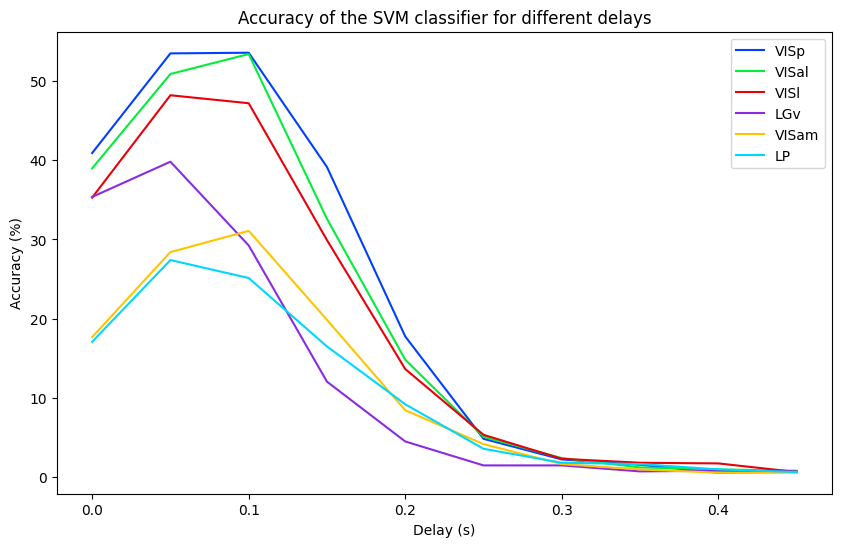

In [74]:
#Plot the results in one plot
plt.figure(figsize=(10, 6))

for area in top_areas.keys():
    mask = df["area"] == area
    plt.plot(df[mask]["delay"], df[mask]["accuracy"], label=area)

plt.xlabel("Delay (s)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy of the SVM classifier for different delays")
plt.legend()

In [88]:
df.head()

,area,delay,accuracy
0,VISp,0.00,40.924370
1,VISp,0.05,53.529412
2,VISp,0.10,53.613445
3,VISp,0.15,39.159664
4,VISp,0.20,17.731092


In [97]:
df.to_csv("C:/Users/jeand/OneDrive/Bureau/Clean_PC/neuroscience project/accuracy.csv", index=False)
